# 모든 장르 간 편향성 측정해 보기

이번 프로젝트에서는 KOBIS에서 제공하는 시놉시스 데이터로 부터 워드임베딩을 구성하고, 해당 임베딩 모델이 데이터간 편향성을 가지는지 확인해보겠다.

- 영화 시놉시스 데이터 : synopsis.zip
 - 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보
 - 출처 : KOBIS (영화관입장권통합전산망:Korean Box Office Information System)


In [ ]:
  #나눔폰트 설치 : 아래 셀 실행후 런타임 재시작
  !sudo apt-get install -y fonts-nanum
  !sudo fc-cache -fv
  !rm ~/.cache/matplotlib -rf

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 64.4 MB/s 
     |████████████████████████████████| 448 kB 45.6 MB/s 


In [ ]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/Aiffel/03_GoingDeeper/06/data/synopsis.zip' -d './synopsis'

In [1]:
import konlpy
import gensim
import sklearn
import seaborn
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')

print(konlpy.__version__)
print(gensim.__version__)   #3.6
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
3.6.0
1.0.2
0.11.2


### 단어 추출
시놉시스 데이터중 명사에 해당하는 단어만 추출한다.

In [3]:
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open('/content/synopsis/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:    # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)


In [4]:
print(len(tokenized)) 

71156


synopsis.txt에서 71,156개의 명사를 추출하였다. 추출한 단어로 100차원의 임베딩 모델를 만들어보자.

### 워드 임베딩 모델 구현
Word2Vec 파라미터
- sentences : 토큰화된 단어 집합
- size : 벡터의 차원수 (단어의 분포차원, 실제 unique vocab 수보다 작아야함.)
- window : 컨텍스트 윈도우 크기. 훈련시 앞 뒤로 고려하는 단어의 개수
- min_count : 최소 빈도수, 해당 빈도수보다 작게 등장한 단어의 경우 모델 학습에서 배제
- sg : 1일 경우 skip-gram, 0일 경우 CBOW
 - skip-gram : 해당 단어를 통해 주변단어를 예측
 - CBOW : 주변 단어를 통해 해당 단어를 예측

In [5]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  # Gensim 3.X 에서 임베딩 모델 생성

### 유사도 테스트
시놉시스 데이터로 만들어진 임베딩 모델에서 비슷한 유사도의 단어들을 확인해보겠다.

In [ ]:
model.most_similar(positive=['영화'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('작품', 0.8924439549446106),
 ('다큐멘터리', 0.8483200073242188),
 ('드라마', 0.8224549293518066),
 ('영화로', 0.797136664390564),
 ('코미디', 0.7903211116790771),
 ('형식', 0.7858985662460327),
 ('실화', 0.7794060707092285),
 ('주제', 0.7774088382720947),
 ('소재', 0.7747283577919006),
 ('감동', 0.7693641185760498)]

In [ ]:
model.wv.most_similar(positive=['송강호'])

[('마동석', 0.9869505763053894),
 ('홉킨스', 0.9862228035926819),
 ('회심', 0.9860907196998596),
 ('에르나니', 0.9857815504074097),
 ('이성재', 0.9856706857681274),
 ('도널드', 0.985228419303894),
 ('프레스턴', 0.9850459098815918),
 ('대인', 0.984865665435791),
 ('뮤', 0.9841469526290894),
 ('백윤식', 0.9839400053024292)]

In [ ]:
model.wv.most_similar(positive=['봉준호'])

[('미완성', 0.966411828994751),
 ('샌포드', 0.9659848213195801),
 ('박찬욱', 0.9657885432243347),
 ('남아공', 0.9638287425041199),
 ('정지영', 0.9633204340934753),
 ('일견', 0.9631582498550415),
 ('압바스', 0.9628732204437256),
 ('리베', 0.9625997543334961),
 ('필름스타', 0.9618345499038696),
 ('기리', 0.9601733684539795)]

영화배우 송강호를 넣었을때는 배우이름들이, 영화감독 봉준호를 넣으니 감독이름이나 관련 단어들이 나타나고 있다.

In [ ]:
model.wv.most_similar(positive=['공포'])

[('현상', 0.8994206786155701),
 ('미스터리', 0.8737364411354065),
 ('혼란', 0.8560728430747986),
 ('소용돌이', 0.8444286584854126),
 ('혼돈', 0.8251901268959045),
 ('엄습', 0.8246563673019409),
 ('의식', 0.8210121393203735),
 ('실체', 0.8205640912055969),
 ('극도', 0.8196173906326294),
 ('결말', 0.81907057762146)]

In [ ]:
model.wv.most_similar(positive=['가족'])

[('어머니', 0.7145949602127075),
 ('분배', 0.7143767476081848),
 ('부모', 0.7082630395889282),
 ('쇼카', 0.6843188405036926),
 ('할레', 0.6730148196220398),
 ('자식', 0.6585677862167358),
 ('화해', 0.6563226580619812),
 ('팡떵', 0.6514015793800354),
 ('여로', 0.6511754989624023),
 ('증조', 0.6498194336891174)]

## 대표 단어 셋 만들기
이제 시놉시스 텍스트 파일을 읽고, 해당 장르를 대표하는 단어를 구성하여 예술영화, 상업영화에 대한 편향성을 확인해보겠다. 

그렇다면 데이터를 대표할 수 있는 단어의 기준은 무엇일까? 이전 LMS에서는 빈도수를 기준으로한 TF-IDF방식을 사용하여 대표 단어를 선정하였다. TF-IDF방식은 특정 문서에 자주나타나는 단어에 가중치를 주는 방식이였는데 상업영화, 예술영화 모두 비슷한 카테고리의 문서이므로 중요도가 높은 단어들이 중복되어 나타났다. 실제 텍스트 파일에서 상업영화임에도 영화제 시상식에서 상을 수상한 영화의 시놉시스들이 다수 포함되어 상업영화라고 예술성이 떨어지지 않아 중복이 많을 수 밖에 없었던것 같다.

attribute_A, attribute_B 단어셋은 개념축이 되는 단어이므로 아래 그래프처럼 대조가 잘 되도록 구성할 필요가 있다. 

![ㅇ](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FNsusk%2FbtrxJrrKmo4%2FiZTHrqcobkcYmZAdJAlxWK%2Fimg.png)

출처 : https://arxiv.org/pdf/2111.07864.pdf


상업영화, 예술영화를 잘 대표하면서도 서로 대조가되는 단어들로 구성하기 위해 본 프로젝트에서는 LDA(잠재 디리클레 할당 : Latent Dirichlet Allocation) 방식을 적용해보겠다. 토픽별 단어셋을 출력해보고 대조가 쉽게되는 토픽의 단어셋을 대표 단어셋으로 설정할 것이다. 

Sets of attribute words에 해당하는 단어셋은 기존의 TF-IDF방식을 그대로 적용하겠다.

- Sets of target words : targets_X, targets_Y
 - 영화 구분
 - targets_X : 예술영화(synopsis_art.txt)
 - targets_Y : 상업영화(synopsis_gen.txt)

-  Sets of attribute words : attribute_A, attribute_B
 - 전체 영화 장르

 >
  ``` 
synopsis_SF.txt: SF
synopsis_가족.txt: 가족
synopsis_공연.txt: 공연
synopsis_공포(호러).txt: 공포(호러)
synopsis_기타.txt: 기타
synopsis_다큐멘터리.txt: 다큐멘터리
synopsis_드라마.txt: 드라마
synopsis_멜로로맨스.txt: 멜로로맨스
synopsis_뮤지컬.txt: 뮤지컬
synopsis_미스터리.txt: 미스터리
synopsis_범죄.txt: 범죄
synopsis_사극.txt: 사극
synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
synopsis_성인물(에로).txt: 성인물(에로)
synopsis_스릴러.txt: 스릴러
synopsis_애니메이션.txt: 애니메이션
synopsis_액션.txt: 액션
synopsis_어드벤처.txt: 어드벤처
synopsis_전쟁.txt: 전쟁
synopsis_코미디.txt: 코미디
synopsis_판타지.txt: 판타지
```

In [6]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []    
    with open('/content/synopsis/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [7]:
len(art), len(gen)

(620208, 3014815)

In [8]:
print(art[0:100])
print(gen[0:100])

사운드 엔지니어 상우 유지태 분 치매 할머니 백성희 분 시절 상처 아버지 박인환 분 고모 신신애 분 살 겨울 그 지방 방송국 라디오 은수 이영애 분 를 자연 소리 채집 라디오 프로
유사 연령 성별 빈부 차이 정치 입장 불문 국민 통합 온 애국심 성역 일침 다큐멘터리 재작년 전국 민족 민주 유가족 협의 회의 장기 농성 인상 다큐멘터리 민들레 를 독립영화 집단 


텍스트 파일에서 명사만 추출하여 문서를 구성하였다. 
- 명사가 아닌경우('를'과 같은 조사, 동사등)도 가끔 포함된것이 보인다.

LDA에 사용할 TF-IDF 단어는 상위 300개로 한정하였다. 
 - 너무 많은 단어를 포함하면 대표성이 없는 토픽들도 추출될수 있기 때문이다.
```
TfidfVectorizer(max_features=300) 
```

In [68]:
from sklearn.decomposition import LatentDirichletAllocation

def get_topics(components, feature_names, n=15):
    dt_topics ={}    
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(4)) for i in topic.argsort()[:-n - 1:-1]])

        list_topic_names = []
        for i in topic.argsort()[:-n-1:-1]:
            list_topic_names.append(feature_names[i])
        
        dt_topics[idx] = list_topic_names
    return dt_topics

In [105]:
# 예술영화 토픽별 단어 추출
vectorizer_art = TfidfVectorizer(max_features=500)
tf_idf_art = vectorizer_art.fit_transform([art])

lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=2000, max_iter=2)
lda_model.fit_transform(tf_idf_art)
terms_art = vectorizer_art.get_feature_names() # 단어 집합
dt_topics_art = get_topics(lda_model.components_, terms_art)

Topic 1: [('탈출', 0.9283), ('직원', 0.9246), ('반대', 0.9119), ('공격', 0.8909), ('도쿄', 0.8886), ('결정', 0.8833), ('목숨', 0.8827), ('여행', 0.8806), ('경찰', 0.8748), ('생존', 0.8678), ('준비', 0.8657), ('오빠', 0.8656), ('배우', 0.8608), ('그날', 0.856), ('작업', 0.8415)]
Topic 2: [('겨울', 0.8979), ('아픔', 0.882), ('한번', 0.8701), ('존재', 0.8682), ('관객', 0.8666), ('자살', 0.8635), ('홀로', 0.8606), ('사회', 0.8592), ('노인', 0.8579), ('살해', 0.8536), ('맞이', 0.8499), ('청춘', 0.8472), ('단편', 0.8457), ('이해', 0.8422), ('형사', 0.8395)]
Topic 3: [('거리', 0.9502), ('부인', 0.9484), ('남자', 0.8668), ('외모', 0.866), ('최악', 0.8615), ('갈등', 0.8477), ('작가', 0.845), ('진실', 0.8434), ('직접', 0.8356), ('아무', 0.8347), ('세계', 0.8347), ('여성', 0.8346), ('안고', 0.8295), ('대상', 0.8288), ('프로젝트', 0.827)]
Topic 4: [('미국', 0.9079), ('임무', 0.8738), ('처음', 0.8619), ('공포', 0.8616), ('이후', 0.8569), ('의심', 0.8535), ('개월', 0.8421), ('로서', 0.8417), ('영화제', 0.8376), ('이유', 0.8366), ('작전', 0.8359), ('오늘', 0.8351), ('목숨', 0.8333), ('머리', 0.8327), ('비밀', 0.8323)]
To

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [103]:
# 상업영화 토픽별 단어 추출
vectorizer_gen = TfidfVectorizer(max_features=500)
tf_idf_gen = vectorizer_gen.fit_transform([gen])

lda_model.fit_transform(tf_idf_gen)
terms_gen = vectorizer_gen.get_feature_names() # 단어 집합
dt_topics_gen = get_topics(lda_model.components_, terms_gen)

Topic 1: [('출장', 1.0627), ('여자', 1.0498), ('불구', 1.043), ('여성', 1.041), ('노래', 1.0328), ('마지막', 1.0287), ('아무', 1.0286), ('선생님', 1.0282), ('점차', 1.0166), ('사진', 1.0164), ('만남', 1.0142), ('마치', 1.0116), ('지금', 1.0115), ('표현', 1.0018), ('가운데', 1.0014)]
Topic 2: [('범죄', 1.1148), ('외모', 1.1072), ('사랑', 1.0682), ('위기', 1.0631), ('납치', 1.0509), ('알렉스', 1.0273), ('진행', 1.0214), ('활동', 1.0135), ('여성', 1.0111), ('밴드', 1.0111), ('만난', 1.0081), ('부천', 1.0062), ('감정', 1.0061), ('경험', 1.0051), ('바로', 1.0037)]
Topic 3: [('대화', 1.0668), ('레이', 1.0459), ('갑자기', 1.0421), ('순간', 1.0352), ('남성', 1.031), ('의사', 1.0223), ('집안', 1.0212), ('고향', 1.0183), ('얘기', 1.0174), ('도시', 1.0106), ('몰래', 1.0084), ('살해', 1.0075), ('성적', 1.002), ('무엇', 0.9901), ('프로젝트', 0.9888)]
Topic 4: [('가게', 1.1409), ('간다', 1.1172), ('부산', 1.1028), ('마침내', 1.0958), ('누군가', 1.0731), ('범인', 1.0535), ('문제', 1.0391), ('사장', 1.0365), ('조직', 1.0335), ('진실', 1.0237), ('린다', 1.0147), ('현실', 1.014), ('인터뷰', 1.0129), ('작품', 1.0103), ('미래', 1.00

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


예술영화와 상업영화에 대해 10가지 토픽을 뽑아 보았다. 

상업영화의 경우 관객들의 흥미 유발을 위해 자극적이며 스릴 있는 스토리를 나타내는 단어, 예술영화는 작가가 말하고자하는 가치관이나 예술성을 위한 연출과 스토리를 나타내는 단어를 포함하는 토픽을 대표 단어셋으로 하겠다.


In [107]:
print(dt_topics_art[8])
print(dt_topics_gen[1])

['생명', '성공', '발견', '중국', '실수', '탄생', '바로', '존재', '하루하루', '그녀', '또한', '우연', '무기', '관심', '전투']
['범죄', '외모', '사랑', '위기', '납치', '알렉스', '진행', '활동', '여성', '밴드', '만난', '부천', '감정', '경험', '바로']


In [71]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [72]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [88]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape) #전체 장르(21개)에 대한 tf-idf

(21, 42191)


In [75]:
m = [X[i].tocoo() for i in range(X.shape[0])]
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 100):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 정체, 친구, 비밀, 사실, 기억, 전쟁, 사건, 시간, 공격, 영화, 한편, 실험, 능력, 시스템, 위협, 생명체, 정부, 아들, 사고, 스타크, 리플리, 과학자, 음모, 파괴, 아버지, 켈빈, 컨트, 모두, 수퍼맨, 임무, 발생, 가족, 요원, 죽음, 다시, 위기, 과거, 외계인, 도시, 이제, 갑자기, 상황, 운명, 분파, 불명, 연구, 개발, 때문, 탈출, 명의, 의문, 남자, 아이, 현실, 바이러스, 상어, 물체, 진화, 목숨, 최후, 통해, 프로젝트, 수트, 생존, 과연, 사랑, 히노키, 섹터, 미국, 여행, 대원, 멸망, 조직, 바로, 위험, 사이, 세력, 감염, 괴물, 거대, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 사람, 학교, 세상, 소년, 슈이트, 이야기, 가장, 어머니, 마갈, 소녀, 미아, 대한, 펠리칸, 모두, 혼자, 서울, 벤트, 케이시, 마음, 사건, 할아버지, 엠마, 고양이, 크리스마스, 아내, 사이, 최호, 요정, 모험, 혜지, 유나, 테리, 위기, 다시, 번개, 손녀, 그레고리, 과연, 결심, 시골, 파코, 작품, 영화, 스튜어트, 해나, 인형, 단편, 기억, 발견, 서로, 하나, 한편, 부산, 아스, 장난감, 도시, 크누드, 누키, 제노, 아기, 때문, 이자, 펠릭스, 노동자, 회사, 생각, 사실, 마르, 주니, 강아지, 간다, 다른, 소식, 시간, 신차, 잉그릿, 제페토, 규완, 우산, 도움, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키, 라다, 무대, 도시, 공작, 리코, 시작, 파우스트, 메스, 결혼, 만토바

각장르를 대표하는 단어 상위 100개씩을 출력해보았다. 

## WEAT 함수
LMS에서 보았던 WEAT score를 구하는 함수를 미리 정의해두겠다.

![d](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FlIdzl%2FbtrxziHrxij%2FJ80Fvy4Cat00YKzynksfb0%2Fimg.png)

In [80]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

target_X 는 art(예술영화 - dt_topics_art[9]), target_Y 는 gen(상업영화 - dt_topics_gen[0])으로 고정하고 attribute_A, attribute_B를 영화 장르 바꿔가면서 WEAT score를 구해보겠다.  

In [108]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model[word] for word in dt_topics_art[8]]) 
Y = np.array([model[word] for word in dt_topics_gen[1]])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model[word] for word in attributes[i]])
        B = np.array([model[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [109]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 0.37366888
SF 공연 0.6314071
SF 공포(호러) 0.1162023
SF 기타 0.3819581
SF 다큐멘터리 0.26611438
SF 드라마 0.33473614
SF 멜로로맨스 0.3304492
SF 뮤지컬 0.58650905
SF 미스터리 0.20474899
SF 범죄 0.48965794
SF 사극 0.6219441
SF 서부극(웨스턴) 0.64099693
SF 성인물(에로) 0.37474144
SF 스릴러 0.25632006
SF 애니메이션 0.26527587
SF 액션 0.6257428
SF 어드벤처 0.26029122
SF 전쟁 0.6587029
SF 코미디 0.48794702
SF 판타지 0.27789143
가족 공연 0.8076109
가족 공포(호러) -0.5284255
가족 기타 0.1658264
가족 다큐멘터리 -0.08879883
가족 드라마 0.022357618
가족 멜로로맨스 0.2175146
가족 뮤지컬 0.56457174
가족 미스터리 -0.3281212
가족 범죄 -0.14236927
가족 사극 0.16488492
가족 서부극(웨스턴) 0.077255376
가족 성인물(에로) 0.3158068
가족 스릴러 -0.25364822
가족 애니메이션 -0.3686079
가족 액션 -0.16140126
가족 어드벤처 -0.5283677
가족 전쟁 0.09027791
가족 코미디 0.63927376
가족 판타지 -0.4462954
공연 공포(호러) -0.7341388
공연 기타 -0.4287723
공연 다큐멘터리 -0.5288567
공연 드라마 -0.69721013
공연 멜로로맨스 -0.13234925
공연 뮤지컬 -0.26514012
공연 미스터리 -0.59553903
공연 범죄 -0.45719635
공연 사극 -0.6206052
공연 서부극(웨스턴) -0.43284845
공연 성인물(에로) -0.00811668
공연 스릴러 -0.545512
공연 애니메이션 -0.9360412
공연 액션 -0.43526226
공연

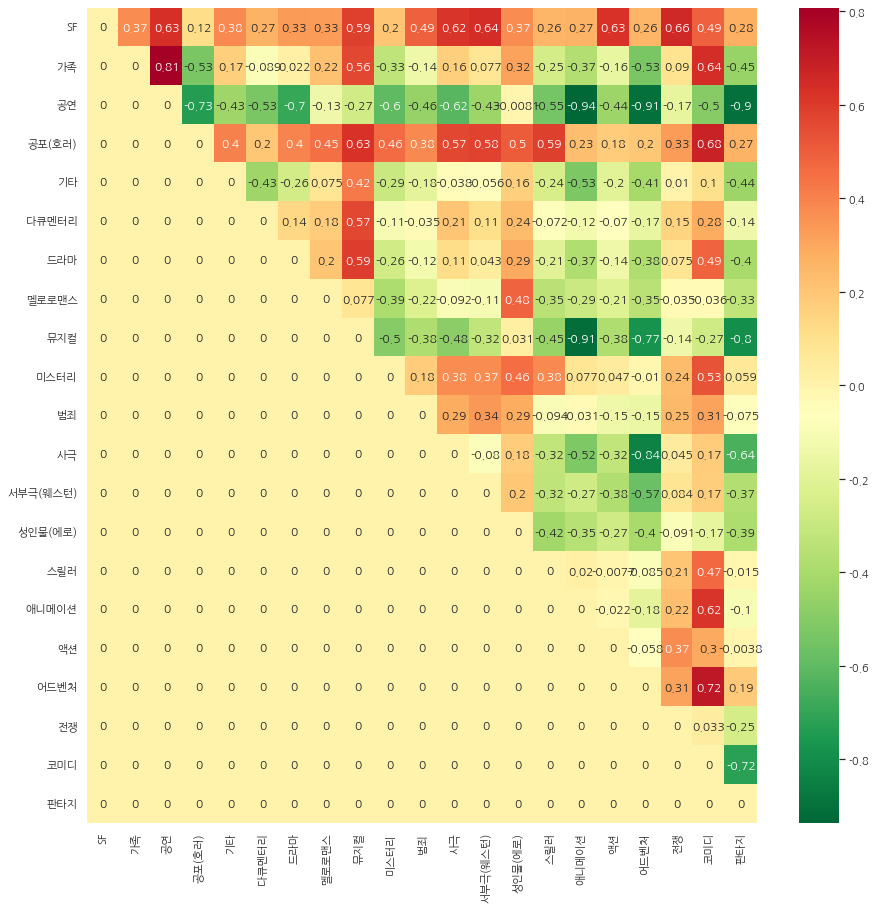

In [113]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)
sns.set(font='NanumGothic') # 한글 지원 폰트

plt.figure(figsize=(15,15))
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

## WEAT Score 분석

- 히트맵에 나타나는 수치는 편향성을 뜻한다. 
 - 0에 가까우면 두 장르간 편향성이 없다고 볼수 있다. (노란색)

- 히트맵에 나타나는 색의 강도는 편향성이 존재함을 나타낸다.
 - 붉은색이 진할수록 y축의 장르는 Target A(예술영화)에 편향되어으며 x축의 장르는 TargetB(상업영화)에 편향되었다고 볼 수있다. 
 - 초록색이 진할 경우는 반대로 y축의 장르는 TargetB(상업영화)에 편향되어으며 x축의 장르는 Target A(예술영화)에 편향되었다고 볼 수있다. 

---
편향성이 나타난 0.7(붉은색), -0.7(초록색) 이상의 점수로 나타난 몇가지 경우를 분석해보자.

1. 가족, 공연 : 0.81
 - 가족영화 장르는 예술영화에, 공연영화장르는 상업영화에 편향되어있다.
2. 어드벤처, 코미디 : 0.72
 - 어드벤처영화 장르는 예술영화에, 코미디영화장르는 상업영화에 편향되어있다.
3. 공연, 애니메이션 : -0.94
 - 공연영화 장르는 상업영화에 애니메이션장르는 예술영화에 편향되어있다.
4. 사극, 어드벤처 : -0.94
 - 사극 장르는 상업영화에 어드벤처장르는 예술영화에 편향되어있다.


히트맵을 전반적으로 볼때 상업영화에 편향된 장르(붉은색)는 SF, 공포, 코미디,  성인물, 전쟁 영화등이였고  예술영화에 편향된 장르(초록색)는 공연, 뮤지컬, 판타지, 애니메이션 장르로 나타났다. 그외의 장르는 상업영화와 예술영화에 편향이 크게 존재하지 않는다고 분석할수 있겠다. 

## Reference
- [Evaluating Metrics for Bias in Word Embeddings](https://arxiv.org/pdf/2111.07864.pdf)